# Deepwalk + Inductive Mean Pooling [DEMO]

-----

In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
from nodevectors import Node2Vec
import xgboost as xgb
from fucc.inductive_step import inductive_pooling
from fucc.metrics import plot_ap, get_optimal_f1_cutoff, get_confusion_matrix
from sklearn.metrics import average_precision_score
import logging
logging.basicConfig(level=logging.INFO)

Dataset source: https://www.kaggle.com/ranjeetshrivastav/fraud-detection-dataset

In [2]:
# Parameters
dimensions = 32
walk_len = 80
walk_num = 10
window_size = 5
# the 'workers' parameter is used for multi-processing.
workers = 8

## Load Data

In [3]:
df = pd.read_json('../transactions/transactions.txt',  lines=True, convert_dates=[4])

In [4]:
# Transform fourth column to datetime format
df.iloc[:, 4] = pd.to_datetime(df.iloc[:, 4])

In [5]:
# Sort dataframe by datetime
df = df.sort_values('transactionDateTime')
# Create a transaction ID
df.loc[:, 'TX_ID'] = range(df.shape[0])

In [6]:
# Rename columns to work with hard-coded feature names in our code
df = df.rename(columns={"merchantName":"TERM_MIDUID", "customerId":"CARD_PAN_ID", "isFraud": "TX_FRAUD" })

- **TERM_MIDUID**: beneficiary of the transaction
- **CARD_PAN_ID**: customer initiating the transaction
- **TX_FRAUD**: fraud label

In [7]:
# Split into train and test set
df_train = df.iloc[:400000]
df_test = df.iloc[400000:500000]

## Create network

In [8]:
# Create tripartite network with transaction, merchant and cardholder nodes
G = nx.Graph()
G.add_nodes_from(df_train.TERM_MIDUID.unique(), type='merchant')
G.add_nodes_from(df_train.CARD_PAN_ID.unique(), type='cardholder')
G.add_nodes_from(df_train.TX_ID.unique(), type='transaction')

# Add edges
G.add_edges_from(zip(df_train.CARD_PAN_ID, df_train.TX_ID))
G.add_edges_from(zip(df_train.TX_ID, df_train.TERM_MIDUID))

In [9]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 407337
Number of edges: 800000
Average degree:   3.9280


## Deepwalk

Fitting the Deepwalk model to the network can take a while depending on your local workstation and the number of 'workers' used for multiprocessing. 

In [11]:
# Fit embedding model to graph
# Node2Vec with p,q=1 is identical to Deepwalk
g2v = Node2Vec(
    n_components=dimensions,
    walklen = walk_len,
    epochs = walk_num,
    w2vparams={'workers': workers, 'window': window_size}
)

g2v.fit(G)
model = g2v.model

Making walks... Done, T=157.94
Mapping Walk Names... 

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types


Done, T=312.78
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues


INFO:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 800000 words, keeping 256848 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #20000, processed 1600000 words, keeping 351125 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #30000, processed 2400000 words, keeping 386251 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #40000, processed 3200000 words, keeping 399400 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #50000, processed 4000000 words, keeping 404374 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #60000, processed 4800000 words, keeping 406239 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #70000, processed 5600000 words, keeping 406929 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #80000, processed 6400000 words, keeping 407204 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #90000, processed 7200000 words, keeping 407292 word types
INFO:gensim.models.w

INFO:gensim.models.word2vec:PROGRESS: at sentence #760000, processed 60800000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #770000, processed 61600000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #780000, processed 62400000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #790000, processed 63200000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #800000, processed 64000000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #810000, processed 64800000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #820000, processed 65600000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #830000, processed 66400000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #840000, processed 67200000 words, keeping 407337 word types
I

INFO:gensim.models.word2vec:PROGRESS: at sentence #1500000, processed 120000000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #1510000, processed 120800000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #1520000, processed 121600000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #1530000, processed 122400000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #1540000, processed 123200000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #1550000, processed 124000000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #1560000, processed 124800000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #1570000, processed 125600000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #1580000, processed 126400000 words, keeping 4

INFO:gensim.models.word2vec:PROGRESS: at sentence #2230000, processed 178400000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #2240000, processed 179200000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #2250000, processed 180000000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #2260000, processed 180800000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #2270000, processed 181600000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #2280000, processed 182400000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #2290000, processed 183200000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #2300000, processed 184000000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #2310000, processed 184800000 words, keeping 4

INFO:gensim.models.word2vec:PROGRESS: at sentence #2960000, processed 236800000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #2970000, processed 237600000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #2980000, processed 238400000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #2990000, processed 239200000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #3000000, processed 240000000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #3010000, processed 240800000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #3020000, processed 241600000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #3030000, processed 242400000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #3040000, processed 243200000 words, keeping 4

INFO:gensim.models.word2vec:PROGRESS: at sentence #3690000, processed 295200000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #3700000, processed 296000000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #3710000, processed 296800000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #3720000, processed 297600000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #3730000, processed 298400000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #3740000, processed 299200000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #3750000, processed 300000000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #3760000, processed 300800000 words, keeping 407337 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #3770000, processed 301600000 words, keeping 4

INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 9.45% examples, 1104453 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 9.80% examples, 1103344 words/s, in_qsize 23, out_qsize 8
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 10.16% examples, 1104107 words/s, in_qsize 32, out_qsize 8
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 10.55% examples, 1105562 words/s, in_qsize 24, out_qsize 7
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 10.94% examples, 1106643 words/s, in_qsize 32, out_qsize 8
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 11.33% examples, 1107658 words/s, in_qsize 23, out_qsize 8
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 11.72% examples, 1110338 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 12.07% examples, 1109965 words/s, in_qsize 24, out_qsize 7
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 12.44% examples, 1110309 words/s, i

INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 36.77% examples, 1138138 words/s, in_qsize 32, out_qsize 3
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 37.13% examples, 1137152 words/s, in_qsize 25, out_qsize 6
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 37.49% examples, 1136809 words/s, in_qsize 24, out_qsize 7
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 37.88% examples, 1137059 words/s, in_qsize 32, out_qsize 6
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 38.25% examples, 1136941 words/s, in_qsize 23, out_qsize 8
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 38.64% examples, 1137134 words/s, in_qsize 23, out_qsize 8
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 39.03% examples, 1137760 words/s, in_qsize 29, out_qsize 2
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 39.39% examples, 1137697 words/s, in_qsize 26, out_qsize 5
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 39.78% examples, 1138386 words/s,

INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 64.14% examples, 1143916 words/s, in_qsize 32, out_qsize 1
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 64.53% examples, 1144025 words/s, in_qsize 30, out_qsize 2
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 64.89% examples, 1143943 words/s, in_qsize 23, out_qsize 8
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 65.28% examples, 1144119 words/s, in_qsize 26, out_qsize 5
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 65.68% examples, 1144377 words/s, in_qsize 26, out_qsize 5
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 66.06% examples, 1144692 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 66.43% examples, 1144591 words/s, in_qsize 24, out_qsize 7
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 66.83% examples, 1144705 words/s, in_qsize 32, out_qsize 3
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 67.21% examples, 1144869 words/s,

INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 90.61% examples, 1134757 words/s, in_qsize 28, out_qsize 3
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 90.95% examples, 1134328 words/s, in_qsize 24, out_qsize 7
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 91.32% examples, 1134305 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 91.67% examples, 1134117 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 92.02% examples, 1133665 words/s, in_qsize 31, out_qsize 1
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 92.38% examples, 1133612 words/s, in_qsize 30, out_qsize 1
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 92.74% examples, 1133502 words/s, in_qsize 30, out_qsize 1
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 93.08% examples, 1132989 words/s, in_qsize 24, out_qsize 7
INFO:gensim.models.base_any2vec:EPOCH 1 - PROGRESS: at 93.45% examples, 1132820 words/s,

INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 11.08% examples, 1016001 words/s, in_qsize 28, out_qsize 3
INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 11.42% examples, 1016439 words/s, in_qsize 26, out_qsize 5
INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 11.77% examples, 1018286 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 12.12% examples, 1019354 words/s, in_qsize 26, out_qsize 5
INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 12.46% examples, 1019603 words/s, in_qsize 25, out_qsize 6
INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 12.81% examples, 1020503 words/s, in_qsize 26, out_qsize 5
INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 13.15% examples, 1020947 words/s, in_qsize 26, out_qsize 5
INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 13.45% examples, 1018489 words/s, in_qsize 32, out_qsize 2
INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 13.80% examples, 1018684 words/s,

INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 36.97% examples, 1067288 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 37.33% examples, 1067641 words/s, in_qsize 28, out_qsize 3
INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 37.70% examples, 1068267 words/s, in_qsize 25, out_qsize 6
INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 38.09% examples, 1069216 words/s, in_qsize 24, out_qsize 7
INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 38.46% examples, 1069879 words/s, in_qsize 32, out_qsize 3
INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 38.83% examples, 1070237 words/s, in_qsize 22, out_qsize 9
INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 39.22% examples, 1071279 words/s, in_qsize 23, out_qsize 8
INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 39.61% examples, 1072499 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 39.96% examples, 1072643 words/s,

INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 64.14% examples, 1099278 words/s, in_qsize 32, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 64.53% examples, 1099502 words/s, in_qsize 24, out_qsize 7
INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 64.92% examples, 1099788 words/s, in_qsize 29, out_qsize 3
INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 65.31% examples, 1100103 words/s, in_qsize 24, out_qsize 7
INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 65.70% examples, 1100411 words/s, in_qsize 24, out_qsize 7
INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 66.07% examples, 1100590 words/s, in_qsize 23, out_qsize 8
INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 66.45% examples, 1100945 words/s, in_qsize 32, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 66.82% examples, 1101153 words/s, in_qsize 28, out_qsize 3
INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 67.20% examples, 1101386 words/s,

INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 91.39% examples, 1113893 words/s, in_qsize 25, out_qsize 6
INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 91.78% examples, 1114278 words/s, in_qsize 32, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 92.16% examples, 1114454 words/s, in_qsize 30, out_qsize 1
INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 92.52% examples, 1114537 words/s, in_qsize 24, out_qsize 7
INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 92.91% examples, 1114895 words/s, in_qsize 28, out_qsize 3
INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 93.29% examples, 1115004 words/s, in_qsize 32, out_qsize 3
INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 93.67% examples, 1115256 words/s, in_qsize 26, out_qsize 5
INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 94.06% examples, 1115352 words/s, in_qsize 32, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 2 - PROGRESS: at 94.45% examples, 1115622 words/s,

INFO:gensim.models.base_any2vec:EPOCH 3 - PROGRESS: at 13.95% examples, 1141508 words/s, in_qsize 32, out_qsize 6
INFO:gensim.models.base_any2vec:EPOCH 3 - PROGRESS: at 14.34% examples, 1142334 words/s, in_qsize 31, out_qsize 4
INFO:gensim.models.base_any2vec:EPOCH 3 - PROGRESS: at 14.74% examples, 1143259 words/s, in_qsize 30, out_qsize 1
INFO:gensim.models.base_any2vec:EPOCH 3 - PROGRESS: at 15.10% examples, 1143311 words/s, in_qsize 23, out_qsize 8
INFO:gensim.models.base_any2vec:EPOCH 3 - PROGRESS: at 15.48% examples, 1143244 words/s, in_qsize 28, out_qsize 3
INFO:gensim.models.base_any2vec:EPOCH 3 - PROGRESS: at 15.84% examples, 1142451 words/s, in_qsize 24, out_qsize 7
INFO:gensim.models.base_any2vec:EPOCH 3 - PROGRESS: at 16.22% examples, 1142740 words/s, in_qsize 32, out_qsize 6
INFO:gensim.models.base_any2vec:EPOCH 3 - PROGRESS: at 16.60% examples, 1143302 words/s, in_qsize 24, out_qsize 7
INFO:gensim.models.base_any2vec:EPOCH 3 - PROGRESS: at 16.99% examples, 1144343 words/s,

INFO:gensim.models.base_any2vec:EPOCH 3 - PROGRESS: at 41.25% examples, 1147409 words/s, in_qsize 32, out_qsize 4
INFO:gensim.models.base_any2vec:EPOCH 3 - PROGRESS: at 41.63% examples, 1147527 words/s, in_qsize 30, out_qsize 1
INFO:gensim.models.base_any2vec:EPOCH 3 - PROGRESS: at 42.00% examples, 1147228 words/s, in_qsize 23, out_qsize 8
INFO:gensim.models.base_any2vec:EPOCH 3 - PROGRESS: at 42.39% examples, 1147792 words/s, in_qsize 32, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 3 - PROGRESS: at 42.76% examples, 1147662 words/s, in_qsize 25, out_qsize 6
INFO:gensim.models.base_any2vec:EPOCH 3 - PROGRESS: at 43.14% examples, 1147621 words/s, in_qsize 21, out_qsize 10
INFO:gensim.models.base_any2vec:EPOCH 3 - PROGRESS: at 43.53% examples, 1148150 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 3 - PROGRESS: at 43.90% examples, 1148020 words/s, in_qsize 24, out_qsize 7
INFO:gensim.models.base_any2vec:EPOCH 3 - PROGRESS: at 44.30% examples, 1148491 words/s

INFO:gensim.models.base_any2vec:EPOCH 3 - PROGRESS: at 68.40% examples, 1147121 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 3 - PROGRESS: at 68.77% examples, 1147018 words/s, in_qsize 24, out_qsize 7
INFO:gensim.models.base_any2vec:EPOCH 3 - PROGRESS: at 69.16% examples, 1147154 words/s, in_qsize 32, out_qsize 5
INFO:gensim.models.base_any2vec:EPOCH 3 - PROGRESS: at 69.56% examples, 1147290 words/s, in_qsize 32, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 3 - PROGRESS: at 69.95% examples, 1147673 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 3 - PROGRESS: at 70.32% examples, 1147623 words/s, in_qsize 24, out_qsize 7
INFO:gensim.models.base_any2vec:EPOCH 3 - PROGRESS: at 70.72% examples, 1147829 words/s, in_qsize 26, out_qsize 5
INFO:gensim.models.base_any2vec:EPOCH 3 - PROGRESS: at 71.08% examples, 1147740 words/s, in_qsize 32, out_qsize 8
INFO:gensim.models.base_any2vec:EPOCH 3 - PROGRESS: at 71.48% examples, 1147937 words/s,

INFO:gensim.models.base_any2vec:EPOCH 3 - PROGRESS: at 96.23% examples, 1154121 words/s, in_qsize 22, out_qsize 9
INFO:gensim.models.base_any2vec:EPOCH 3 - PROGRESS: at 96.63% examples, 1154313 words/s, in_qsize 26, out_qsize 5
INFO:gensim.models.base_any2vec:EPOCH 3 - PROGRESS: at 97.01% examples, 1154331 words/s, in_qsize 32, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 3 - PROGRESS: at 97.41% examples, 1154394 words/s, in_qsize 31, out_qsize 7
INFO:gensim.models.base_any2vec:EPOCH 3 - PROGRESS: at 97.80% examples, 1154464 words/s, in_qsize 24, out_qsize 7
INFO:gensim.models.base_any2vec:EPOCH 3 - PROGRESS: at 98.19% examples, 1154611 words/s, in_qsize 26, out_qsize 5
INFO:gensim.models.base_any2vec:EPOCH 3 - PROGRESS: at 98.58% examples, 1154627 words/s, in_qsize 32, out_qsize 7
INFO:gensim.models.base_any2vec:EPOCH 3 - PROGRESS: at 98.98% examples, 1154708 words/s, in_qsize 25, out_qsize 6
INFO:gensim.models.base_any2vec:EPOCH 3 - PROGRESS: at 99.37% examples, 1154937 words/s,

INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 19.43% examples, 1177350 words/s, in_qsize 23, out_qsize 8
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 19.82% examples, 1177155 words/s, in_qsize 22, out_qsize 9
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 20.21% examples, 1177498 words/s, in_qsize 24, out_qsize 7
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 20.61% examples, 1178288 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 20.98% examples, 1177641 words/s, in_qsize 25, out_qsize 6
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 21.37% examples, 1177416 words/s, in_qsize 24, out_qsize 7
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 21.76% examples, 1177049 words/s, in_qsize 32, out_qsize 7
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 22.15% examples, 1176991 words/s, in_qsize 23, out_qsize 8
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 22.55% examples, 1176860 words/s,

INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 47.36% examples, 1173714 words/s, in_qsize 27, out_qsize 4
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 47.75% examples, 1173541 words/s, in_qsize 32, out_qsize 5
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 48.14% examples, 1173794 words/s, in_qsize 27, out_qsize 4
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 48.53% examples, 1173999 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 48.89% examples, 1173407 words/s, in_qsize 23, out_qsize 8
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 49.28% examples, 1173453 words/s, in_qsize 25, out_qsize 6
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 49.68% examples, 1173538 words/s, in_qsize 32, out_qsize 6
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 50.07% examples, 1173580 words/s, in_qsize 25, out_qsize 6
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 50.46% examples, 1173724 words/s,

INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 75.05% examples, 1170431 words/s, in_qsize 29, out_qsize 2
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 75.42% examples, 1170222 words/s, in_qsize 30, out_qsize 1
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 75.80% examples, 1170270 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 76.18% examples, 1170268 words/s, in_qsize 32, out_qsize 3
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 76.57% examples, 1170215 words/s, in_qsize 26, out_qsize 5
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 76.96% examples, 1170281 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 77.34% examples, 1170308 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 77.71% examples, 1170060 words/s, in_qsize 22, out_qsize 9
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 78.10% examples, 1169990 words/s,

INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 6 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 5 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 4 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 3 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 4 : training on 325869600 raw words (311326539 effective words) took 266.0s, 1170396 effective words/s
INFO:gensim.models.base_any2vec:EPOCH 5 - PROGRESS: at 0.47% examples, 1409380 words/s, in_qsize 31, out_qsize 2
INFO:gensim.models.base_any2vec:EPOCH 5 - PROGRESS: at 0.86% examples, 1313802 words/s, in_qsize 32, out_qsize 5
I

INFO:gensim.models.base_any2vec:EPOCH 5 - PROGRESS: at 25.92% examples, 1175386 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 5 - PROGRESS: at 26.30% examples, 1174813 words/s, in_qsize 23, out_qsize 8
INFO:gensim.models.base_any2vec:EPOCH 5 - PROGRESS: at 26.69% examples, 1175528 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 5 - PROGRESS: at 27.05% examples, 1174177 words/s, in_qsize 26, out_qsize 11
INFO:gensim.models.base_any2vec:EPOCH 5 - PROGRESS: at 27.45% examples, 1175023 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 5 - PROGRESS: at 27.84% examples, 1175031 words/s, in_qsize 30, out_qsize 1
INFO:gensim.models.base_any2vec:EPOCH 5 - PROGRESS: at 28.21% examples, 1174500 words/s, in_qsize 24, out_qsize 7
INFO:gensim.models.base_any2vec:EPOCH 5 - PROGRESS: at 28.60% examples, 1174928 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 5 - PROGRESS: at 28.97% examples, 1174108 words/s

INFO:gensim.models.base_any2vec:EPOCH 5 - PROGRESS: at 53.71% examples, 1172781 words/s, in_qsize 27, out_qsize 4
INFO:gensim.models.base_any2vec:EPOCH 5 - PROGRESS: at 54.10% examples, 1172868 words/s, in_qsize 27, out_qsize 4
INFO:gensim.models.base_any2vec:EPOCH 5 - PROGRESS: at 54.49% examples, 1172590 words/s, in_qsize 32, out_qsize 1
INFO:gensim.models.base_any2vec:EPOCH 5 - PROGRESS: at 54.88% examples, 1172596 words/s, in_qsize 24, out_qsize 7
INFO:gensim.models.base_any2vec:EPOCH 5 - PROGRESS: at 55.27% examples, 1172585 words/s, in_qsize 22, out_qsize 9
INFO:gensim.models.base_any2vec:EPOCH 5 - PROGRESS: at 55.66% examples, 1172543 words/s, in_qsize 24, out_qsize 7
INFO:gensim.models.base_any2vec:EPOCH 5 - PROGRESS: at 56.05% examples, 1172570 words/s, in_qsize 30, out_qsize 1
INFO:gensim.models.base_any2vec:EPOCH 5 - PROGRESS: at 56.45% examples, 1172634 words/s, in_qsize 29, out_qsize 2
INFO:gensim.models.base_any2vec:EPOCH 5 - PROGRESS: at 56.84% examples, 1172598 words/s,

INFO:gensim.models.base_any2vec:EPOCH 5 - PROGRESS: at 81.54% examples, 1172069 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 5 - PROGRESS: at 81.91% examples, 1171801 words/s, in_qsize 31, out_qsize 5
INFO:gensim.models.base_any2vec:EPOCH 5 - PROGRESS: at 82.30% examples, 1171927 words/s, in_qsize 26, out_qsize 5
INFO:gensim.models.base_any2vec:EPOCH 5 - PROGRESS: at 82.70% examples, 1171905 words/s, in_qsize 26, out_qsize 5
INFO:gensim.models.base_any2vec:EPOCH 5 - PROGRESS: at 83.08% examples, 1171981 words/s, in_qsize 32, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 5 - PROGRESS: at 83.45% examples, 1171728 words/s, in_qsize 32, out_qsize 5
INFO:gensim.models.base_any2vec:EPOCH 5 - PROGRESS: at 83.83% examples, 1171836 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 5 - PROGRESS: at 84.23% examples, 1172004 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 5 - PROGRESS: at 84.60% examples, 1171740 words/s,

Done, T=1533.34


In [12]:
# Retrieve for each transaction the associated embedding
embeddings = {}
for i in df_train.TX_ID:
    embeddings[i] = model.wv[str(i)]


embeddings = pd.DataFrame().from_dict(embeddings, orient='index')

In [13]:
# Merge training data with the generated embeddings
df_train = df_train.merge(embeddings, left_on='TX_ID', right_index=True)

In [14]:
df_train.head()

accountNumber  CARD_PAN_ID  creditLimit  availableMoney  \
640789      419104777    419104777        50000         50000.0   
28946       674577133    674577133         5000          5000.0   
222211      958438658    958438658        20000         20000.0   
470320      851126461    851126461        10000         10000.0   
704106      148963316    148963316         2500          2500.0   

       transactionDateTime  transactionAmount      TERM_MIDUID acqCountry  \
640789 2016-01-01 00:01:02              44.09  Washington Post         US   
28946  2016-01-01 00:01:44             329.57      staples.com         US   
222211 2016-01-01 00:01:47             164.57    cheapfast.com         US   
470320 2016-01-01 00:02:04             122.83     discount.com         US   
704106 2016-01-01 00:02:19               0.00      Fast Repair         US   

       merchantCountryCode posEntryMode  ...        22        23        24  \
640789                  US           09  ... -0.029705  4.003897  0.264980   
28946                   US           09  ...  2.213714 -1.430420  1.282415   
222211                  US           05  ...  0.248146 -1.328433  2.064569   
470320                  US           02  ...  0.803404 -1.841866 -0.827956   
704106                  US           05  ... -1.844020 -0.082864 -0.513281   

              25        26        27        28        29        30        31  
640789 -1.035715 -1.068444  0.743573  1.663509 -1.621224  0.263588 -1.414839  
28946  -1.352970  0.162657 -0.341314 -1.537685  2.441593 -6.389329  1.348025  
222211 -0.076046  1.129868  0.408788 -1.121643 -1.124279 -4.102355  0.131869  
470320  0.961063 -1.317324  0.804946  0.816518 -2.253563 -1.086975  2.596497  
704106  2.048566 -1.085432  0.806405 -1.091438 -1.369045  0.063303  2.389175  

[5 rows x 62 columns]

## Inductive Pooling

In [15]:
# Apply inductive mean pooling
results = inductive_pooling(df=df_test, embeddings=embeddings, G=G, workers=workers)

In [16]:
df_new_embeddings = pd.concat([pd.DataFrame(li).transpose() for li in results])

In [17]:
# Merge test data with the inductively generated embeddings
df_new_embeddings.index = df_test.TX_ID
df_test = df_test.merge(df_new_embeddings, left_on='TX_ID', right_index=True)

## XGBoost Classifier

In [18]:
# Only use the embeddings as input features for XGBoost
embedding_features = [i for i in range(dimensions)]

In [19]:
# Final 20% of training data is used as validation set
X_train = df_train[embedding_features].iloc[:int(df_train.shape[0]*0.8)]
X_val = df_train[embedding_features].iloc[int(df_train.shape[0]*0.8):]
y_train = df_train.TX_FRAUD.iloc[:int(df_train.shape[0]*0.8)]
y_val = df_train.TX_FRAUD.iloc[int(df_train.shape[0]*0.8):]

X_test = df_test[embedding_features]
y_test = df_test.TX_FRAUD

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [20]:
# These parameters are not necessarily optimal! Hyperparameter tuning could further improve performance.
xgb_params = {
    'eval_metric': ['auc','aucpr', 'logloss'],
    'objective':'binary:logistic',
    'n_estimators': 300,
    'n_jobs':8,
    'learning_rate':0.1,
    'seed':42,
    'colsample_bytree':0.6,
    'colsample_bylevel':0.9,
    'subsample':0.9
}

In [21]:
model = xgb.train(xgb_params, dtrain, num_boost_round=xgb_params['n_estimators'], evals=[(dval, 'val'), (dtrain, 'train')], early_stopping_rounds=int(xgb_params['n_estimators']/2))

[11:53:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	val-auc:0.62736	val-aucpr:0.05874	val-logloss:0.60404	train-auc:0.61714	train-aucpr:0.06494	train-logloss:0.60408
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 150 rounds.
[1]	val-auc:0.64297	val-aucpr:0.08215	val-logloss:0.53106	train-auc:0.65190	train-aucpr:0.09621	train-logloss:0.53132
[2]	val-auc:0.64627	val-aucpr:0.08545	val-logloss:0.47033	train-auc:0.65656	train-aucpr:0.10274	train-logloss:0.47075
[3]	val-auc:0.65114	val-aucpr:0.09963	val-logloss:0.41911	train-auc:0.66582	train-aucpr:0.12018	train-lo

[65]	val-auc:0.71654	val-aucpr:0.17229	val-logloss:0.07222	train-auc:0.82858	train-aucpr:0.24707	train-logloss:0.07078
[66]	val-auc:0.71674	val-aucpr:0.17274	val-logloss:0.07218	train-auc:0.83107	train-aucpr:0.24887	train-logloss:0.07064
[67]	val-auc:0.71708	val-aucpr:0.17392	val-logloss:0.07211	train-auc:0.83279	train-aucpr:0.25164	train-logloss:0.07043
[68]	val-auc:0.71709	val-aucpr:0.17396	val-logloss:0.07207	train-auc:0.83340	train-aucpr:0.25191	train-logloss:0.07034
[69]	val-auc:0.71678	val-aucpr:0.17397	val-logloss:0.07204	train-auc:0.83457	train-aucpr:0.25310	train-logloss:0.07021
[70]	val-auc:0.71678	val-aucpr:0.17412	val-logloss:0.07203	train-auc:0.83577	train-aucpr:0.25381	train-logloss:0.07014
[71]	val-auc:0.71620	val-aucpr:0.17406	val-logloss:0.07203	train-auc:0.83665	train-aucpr:0.25458	train-logloss:0.07007
[72]	val-auc:0.71678	val-aucpr:0.17536	val-logloss:0.07198	train-auc:0.83780	train-aucpr:0.25620	train-logloss:0.06997
[73]	val-auc:0.71746	val-aucpr:0.17625	val-loglo

[134]	val-auc:0.72721	val-aucpr:0.18866	val-logloss:0.07082	train-auc:0.88875	train-aucpr:0.34043	train-logloss:0.06440
[135]	val-auc:0.72710	val-aucpr:0.18853	val-logloss:0.07083	train-auc:0.88895	train-aucpr:0.34107	train-logloss:0.06436
[136]	val-auc:0.72721	val-aucpr:0.18858	val-logloss:0.07081	train-auc:0.88992	train-aucpr:0.34269	train-logloss:0.06426
[137]	val-auc:0.72695	val-aucpr:0.18901	val-logloss:0.07081	train-auc:0.89045	train-aucpr:0.34411	train-logloss:0.06420
[138]	val-auc:0.72705	val-aucpr:0.18907	val-logloss:0.07081	train-auc:0.89093	train-aucpr:0.34542	train-logloss:0.06415
[139]	val-auc:0.72684	val-aucpr:0.18902	val-logloss:0.07082	train-auc:0.89112	train-aucpr:0.34610	train-logloss:0.06412
[140]	val-auc:0.72701	val-aucpr:0.18922	val-logloss:0.07081	train-auc:0.89146	train-aucpr:0.34691	train-logloss:0.06408
[141]	val-auc:0.72685	val-aucpr:0.18938	val-logloss:0.07080	train-auc:0.89205	train-aucpr:0.34787	train-logloss:0.06402
[142]	val-auc:0.72676	val-aucpr:0.18944	

[203]	val-auc:0.73202	val-aucpr:0.19648	val-logloss:0.07022	train-auc:0.91760	train-aucpr:0.41821	train-logloss:0.06034
[204]	val-auc:0.73217	val-aucpr:0.19638	val-logloss:0.07022	train-auc:0.91796	train-aucpr:0.41986	train-logloss:0.06021
[205]	val-auc:0.73221	val-aucpr:0.19638	val-logloss:0.07022	train-auc:0.91828	train-aucpr:0.42117	train-logloss:0.06015
[206]	val-auc:0.73208	val-aucpr:0.19636	val-logloss:0.07022	train-auc:0.91868	train-aucpr:0.42218	train-logloss:0.06009
[207]	val-auc:0.73228	val-aucpr:0.19637	val-logloss:0.07022	train-auc:0.91917	train-aucpr:0.42366	train-logloss:0.06001
[208]	val-auc:0.73219	val-aucpr:0.19643	val-logloss:0.07021	train-auc:0.91970	train-aucpr:0.42476	train-logloss:0.05991
[209]	val-auc:0.73245	val-aucpr:0.19647	val-logloss:0.07019	train-auc:0.92030	train-aucpr:0.42668	train-logloss:0.05981
[210]	val-auc:0.73277	val-aucpr:0.19647	val-logloss:0.07018	train-auc:0.92106	train-aucpr:0.42890	train-logloss:0.05970
[211]	val-auc:0.73287	val-aucpr:0.19661	

[272]	val-auc:0.73503	val-aucpr:0.20290	val-logloss:0.06974	train-auc:0.94331	train-aucpr:0.50269	train-logloss:0.05561
[273]	val-auc:0.73488	val-aucpr:0.20336	val-logloss:0.06972	train-auc:0.94361	train-aucpr:0.50477	train-logloss:0.05550
[274]	val-auc:0.73489	val-aucpr:0.20329	val-logloss:0.06972	train-auc:0.94368	train-aucpr:0.50534	train-logloss:0.05547
[275]	val-auc:0.73513	val-aucpr:0.20373	val-logloss:0.06970	train-auc:0.94410	train-aucpr:0.50704	train-logloss:0.05539
[276]	val-auc:0.73488	val-aucpr:0.20372	val-logloss:0.06971	train-auc:0.94421	train-aucpr:0.50775	train-logloss:0.05535
[277]	val-auc:0.73506	val-aucpr:0.20421	val-logloss:0.06968	train-auc:0.94474	train-aucpr:0.51018	train-logloss:0.05522
[278]	val-auc:0.73495	val-aucpr:0.20415	val-logloss:0.06968	train-auc:0.94497	train-aucpr:0.51174	train-logloss:0.05515
[279]	val-auc:0.73486	val-aucpr:0.20417	val-logloss:0.06968	train-auc:0.94501	train-aucpr:0.51202	train-logloss:0.05514
[280]	val-auc:0.73475	val-aucpr:0.20429	

In [22]:
y_pred_proba = model.predict(dtest)

## Evaluation

Calculate important classification metrics and plot precision recall curve.

In [23]:
ap = average_precision_score(y_test, y_pred_proba)
print("Average Precision: ", np.round(ap,2))

Average Precision:  0.23


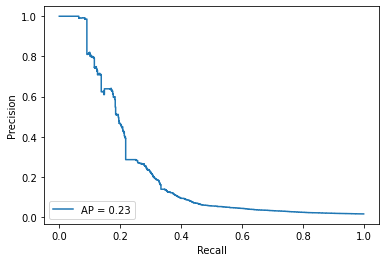

In [24]:
fig = plot_ap(y_test, y_pred_proba)

In [25]:
optimal_threshold, optimal_f1_score = get_optimal_f1_cutoff(y_test, y_pred_proba)
print("F1 Score: ", np.round(optimal_f1_score, 4))

F1 Score:  0.2837


In [26]:
cm = get_confusion_matrix(y_test, y_pred_proba, optimal_threshold)
print("Confusion Matrix: \n", cm)

Confusion Matrix: 
 [[98004   451]
 [ 1215   330]]


In [27]:
from sklearn.metrics import roc_auc_score

In [28]:
roc_auc_score(y_test, y_pred_proba)

0.7493650492339656